In [123]:
import numpy as np
import math
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, assemble, transpile
from qiskit.visualization import plot_histogram

In [121]:
def grey_code(n):
        return n ^ (n >> 1)
    
addrs = [grey_code(n) for n in range(8)]
addrs

[0, 1, 3, 2, 6, 7, 5, 4]

In [108]:
def qrom(database, name="db", barriers=False):
    # Check if database is binary
    assert ((database == 0) | (database == 1)).all()
    
    def encode_row(i):
        row = database[i]
        for j in range(len(row)):
            if row[j] == 1:
                qc.mct(addr_qreg, data_qreg[j])

    def bit_diff_pos(a, b):
        return (addrs[i] ^ addrs[i-1]).bit_length() - 1

    def grey_code(n):
        return n ^ (n >> 1)
    
    nrows, ncols = database.shape
    addr_size = math.ceil(math.log2(nrows))
    addrs = [grey_code(n) for n in range(nrows)]
    
    addr_qreg = QuantumRegister(addr_size, name=f"{name}-address")
    data_qreg = QuantumRegister(ncols, name=f"{name}-data")
    
    qc = QuantumCircuit(addr_qreg, data_qreg)
    
    qc.x(addr_qreg)
    encode_row(0)
    
    if barriers: qc.barrier()
    
    for i in range(1, len(addrs)):
        qc.x(addr_qreg[bit_diff_pos(addrs[i], addrs[i-1])])
        encode_row(i)
        if barriers: qc.barrier()

    # qc.x(addr_qreg[bit_diff_pos(addrs[0], addrs[-1])])
    
    return qc

## Demo

In [116]:
database = np.random.randint(0, 2, (4,4))
database

array([[1, 1, 1, 1],
       [1, 1, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 1, 0]])

### Functionality

In [117]:
nrows, ncols = database.shape
addr_size = math.ceil(math.log2(nrows))

addr_qreg = QuantumRegister(addr_size, name=f"address")
data_qreg = QuantumRegister(ncols, name=f"data")

qc = QuantumCircuit(addr_qreg, data_qreg)

qc.x(addr_qreg[0])

qc.barrier()

qdb = qrom(database, barriers=True)

qdb.draw()
# qc.append(qdb, [*addr_qreg, *data_qreg])

# qc.measure_all()

# qc.draw()

┌───┐                     ░ ┌───┐           ░            ░ ┌───┐»
db-address_0: ┤ X ├──■────■────■────■───░─┤ X ├──■────■───░────────■───░─┤ X ├»
              ├───┤  │    │    │    │   ░ └───┘  │    │   ░ ┌───┐  │   ░ └───┘»
db-address_1: ┤ X ├──■────■────■────■───░────────■────■───░─┤ X ├──■───░──────»
              └───┘┌─┴─┐  │    │    │   ░      ┌─┴─┐  │   ░ └───┘  │   ░      »
   db-data_0: ─────┤ X ├──┼────┼────┼───░──────┤ X ├──┼───░────────┼───░──────»
                   └───┘┌─┴─┐  │    │   ░      └───┘┌─┴─┐ ░      ┌─┴─┐ ░      »
   db-data_1: ──────────┤ X ├──┼────┼───░───────────┤ X ├─░──────┤ X ├─░──────»
                        └───┘┌─┴─┐  │   ░           └───┘ ░      └───┘ ░      »
   db-data_2: ───────────────┤ X ├──┼───░─────────────────░────────────░──────»
                             └───┘┌─┴─┐ ░                 ░            ░      »
   db-data_3: ────────────────────┤ X ├─░─────────────────░────────────░──────»
                                  └───┘ ░                 ░            ░      »
«                         ░ 
«db-address_0: ──■────■───░─
«                │    │   ░ 
«db-address_1: ──■────■───░─
«              ┌─┴─┐  │   ░ 
«   db-data_0: ┤ X ├──┼───░─
«              └───┘  │   ░ 
«   db-data_1: ───────┼───░─
«                   ┌─┴─┐ ░ 
«   db-data_2: ─────┤ X ├─░─
«                   └───┘ ░ 
«   db-data_3: ───────────░─
«                         ░

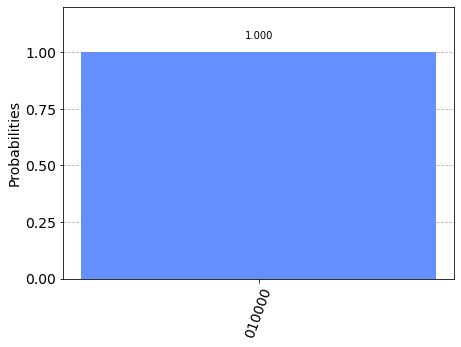

In [110]:
aer_sim = Aer.get_backend("aer_simulator")
qobj = assemble(transpile(qc, aer_sim))
result = aer_sim.run(qobj).result()
counts = result.get_counts()
plot_histogram(counts)

### Internals

In [98]:
qdb = qrom(database, barriers=True)
qdb.draw()

┌───┐                ░ ┌───┐      ░                 ░ ┌───┐     »
db-address_0: ┤ X ├──■────■────■───░─┤ X ├──■───░────────■────■───░─┤ X ├──■──»
              ├───┤  │    │    │   ░ └───┘  │   ░ ┌───┐  │    │   ░ └───┘  │  »
db-address_1: ┤ X ├──■────■────■───░────────■───░─┤ X ├──■────■───░────────■──»
              └───┘┌─┴─┐  │    │   ░        │   ░ └───┘┌─┴─┐  │   ░      ┌─┴─┐»
   db-data_0: ─────┤ X ├──┼────┼───░────────┼───░──────┤ X ├──┼───░──────┤ X ├»
                   └───┘┌─┴─┐  │   ░        │   ░      └───┘  │   ░      └───┘»
   db-data_1: ──────────┤ X ├──┼───░────────┼───░─────────────┼───░───────────»
                        └───┘┌─┴─┐ ░      ┌─┴─┐ ░             │   ░           »
   db-data_2: ───────────────┤ X ├─░──────┤ X ├─░─────────────┼───░───────────»
                             └───┘ ░      └───┘ ░           ┌─┴─┐ ░           »
   db-data_3: ─────────────────────░────────────░───────────┤ X ├─░───────────»
                                   ░            ░           └───┘ ░           »
«               ░ ┌───┐
«db-address_0: ─░─┤ X ├
«               ░ └───┘
«db-address_1: ─░──────
«               ░      
«   db-data_0: ─░──────
«               ░      
«   db-data_1: ─░──────
«               ░      
«   db-data_2: ─░──────
«               ░      
«   db-data_3: ─░──────
«               ░